# Transforming News Articles to CSVs
We acquired monthly business, politics and sports articles from online!

In [1]:
import csv
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

ticker = "<filename>"
date   = "<date>"
news   = "<newstype>"

def get_csv(ticker):
    with open(ticker+".txt","r") as file, open(f'{ticker}.csv','w') as fd:
        csv_in  = csv.reader(file, skipinitialspace=True)
        csv_out = csv.writer(fd,quoting=csv.QUOTE_NONNUMERIC)
        lst = [str(" ".join(line)) for line in csv_in if line]
        df = pd.DataFrame(lst,columns=["text"])
        df["date"] = date
        df["news"] = news
        cols = ['date','news','text']
        df = df.reindex(columns=cols)
        df.to_csv(fd, header=False)

# Get Master Dataframe with All Topics
We parse through each CSV topic article and then read them into a master dataframe consisting a datetime, news type, and text column. Each article row pertains to a paragraph!

In [2]:
def get_master_df():
    numbers = ["1","2","3","4","5","6","7","8","9","10"]
    letters = ["B","P","S"]
    df_list = list()
    path = "2_csv_text/"
    for letter in letters:
        for num in numbers:
            file = letter + num
            df = pd.read_csv(path+file+".csv",header=None)
            df.drop(df.columns[0], axis=1,inplace=True)
            df_list.append(df)
    df = pd.concat(df_list,ignore_index=True)
    df.columns = ["date","news","text"]
    df["date"] = pd.to_datetime(df["date"], format='%m-%d-%Y')
    count = df['text'].str.split().str.len()
    return df[~(count < 4)]

# Imports - Part I.

In [5]:
import re
import nltk
import spacy
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Part of Speech Tagging

In [6]:
# Wordnet Part of Speech
def get_pos(tag):
    if tag.startswith('J'):   return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('R'): return wordnet.ADV
    else: 
        return wordnet.NOUN

# Stop Word Removal & Lemmatizing

In [7]:
# Stop Words Removal & Lemmatizing
spacy_nlp = spacy.load('en_core_web_sm')
lemmatizer = WordNetLemmatizer()

remove_stops  = spacy.lang.en.stop_words.STOP_WORDS
nltk_stops   = stopwords.words('english')
custom_stops = [".com","say","year","a","b","c","d","e","f","g","h","i","j",
                "k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]

for word in nltk_stops:
    spacy_nlp.vocab[word].is_stop = True
    
def tokenize_lemmatize_removestops(text):
    tokens = [token.text for token in spacy_nlp(text) if not token.is_stop]
    tokenized_pos = nltk.pos_tag(tokens)
    tokens_lemmatized = [lemmatizer.lemmatize(word,get_pos(tag)) for word,tag in tokenized_pos]
    no_spaces = list(filter(lambda word: re.sub(r'[\W_]+','', word), tokens_lemmatized))
    processed = list(filter(lambda word: word not in custom_stops, no_spaces))
    return processed

# Applying the Pre-Processing Functions

In [8]:
# Applying NLP to Dataframe
df = get_master_df()
df['re_text'] = df.text.apply(lambda text: re.sub("'|\.|\s+|\d+|[^a-zA-Z0-9]"," ", str(text).lower()))
df['clean_text'] = df.re_text.apply(lambda text: tokenize_lemmatize_removestops(text))
df.dropna(inplace=True)

pd.options.display.max_colwidth = 250
df.head()

date      news  \
0 2019-03-08  Business   
1 2019-03-08  Business   
2 2019-03-08  Business   
3 2019-03-08  Business   
4 2019-03-08  Business   

                                                                                                                                                                                                                                                        text  \
0                                                                                                                                                                                   Protecting The 'Unbanked' By Banning Cashless Businesses In Philadelphia   
1                                              Philadelphia just became the first large city in the nation to ban cashless businesses in the city in part to protect people like Dwight Tindal a construction worker who doesn't have a bank or credit card.   
2  Back in December the Philadelphia City Council passed "Fair Workweek" legislation joining a growing national movement aimed at giving retail and fast-food workers more predictable schedules and by extension more predictable lives. Low-income resi...   
3                                                                                                                                                               That's typically how it works. Advocates shine a light on a problem. A bill gets introduced.   
4                                                                                                                  That's not the way it worked with another new law in Philadelphia. That law can be traced back to one man: City Councilman Bill Greenlee.   

                                                                                                                                                                                                                                                     re_text  \
0                                                                                                                                                                                   protecting the  unbanked  by banning cashless businesses in philadelphia   
1                                              philadelphia just became the first large city in the nation to ban cashless businesses in the city in part to protect people like dwight tindal a construction worker who doesn t have a bank or credit card    
2  back in december the philadelphia city council passed  fair workweek  legislation joining a growing national movement aimed at giving retail and fast food workers more predictable schedules and by extension more predictable lives  low income resi...   
3                                                                                                                                                               that s typically how it works  advocates shine a light on a problem  a bill gets introduced    
4                                                                                                                  that s not the way it worked with another new law in philadelphia  that law can be traced back to one man  city councilman bill greenlee    

                                                                                                                                                                                                                                                  clean_text  
0                                                                                                                                                                                                 [protect, unbanked, ban, cashless, business, philadelphia]  
1                                                                                                        [philadelphia, large, city, nation, ban, cashless, business, city, protect, people, like, dwight, tindal, construction, worker, bank, credit, card]  
2  [december

# Dividing Master DF by News Category

In [9]:
business = (df["news"] == "Business")
politics = (df["news"] == "Politics")
sports   = (df["news"] == "Sports")

df_business = df[business]['clean_text'].values
df_politics = df[politics]['clean_text'].values
df_sports   = df[sports]['clean_text'].values
df_master   = df['clean_text'].values

print("df_business.shape :", df_business.shape)
print("df_politics.shape :", df_politics.shape)
print("df_sports.shape   :", df_sports.shape)
print("\nsummed up equals...")
print("df_master.shape   =", df_master.shape)

df_business.shape : (259,)
df_politics.shape : (351,)
df_sports.shape   : (214,)

summed up equals...
df_master.shape   = (824,)


# Finding Valuable Bi-Grams In Clean Text

In [12]:
from gensim.models.phrases import Phrases, Phraser

# Final Pre-Processing Making Bi-Grams
text = [doc for doc in df_master]
phrases = Phrases(text, min_count=1, threshold=2)
bigram  = Phraser(phrases)

def get_bigrams(df):
    df      = [doc for doc in df]
    tokens  = [bigram[line] for line in df]
    print(tokens[2],"\n")
    return tokens
    
tokens_business = get_bigrams(df_business)
tokens_politics = get_bigrams(df_politics)
tokens_sports   = get_bigrams(df_sports)
tokens_master   = get_bigrams(df_master)

['december', 'philadelphia_city', 'council', 'pass', 'fair', 'workweek', 'legislation', 'join', 'grow', 'national', 'movement', 'aim', 'give', 'retail', 'fast', 'food', 'worker', 'predictable', 'schedule', 'extension', 'predictable', 'life', 'low_income', 'resident', 'union', 'lobby', 'lawmaker', 'issue', 'radar', 'similar', 'law', 'book', 'new_york', 'san_francisco', 'seattle'] 

['heidi_allen', 'group_hop', 'attract', 'candidate', 'walk', 'life'] 

['think', 'night', 'smart_thing', 'wade', 'honest', 'expletive', 'tire', 'deal', 'thing_like', 'expletive', 'sick', 'deal', 'expletive', 'like_expletive', 'complicate'] 

['december', 'philadelphia_city', 'council', 'pass', 'fair', 'workweek', 'legislation', 'join', 'grow', 'national', 'movement', 'aim', 'give', 'retail', 'fast', 'food', 'worker', 'predictable', 'schedule', 'extension', 'predictable', 'life', 'low_income', 'resident', 'union', 'lobby', 'lawmaker', 'issue', 'radar', 'similar', 'law', 'book', 'new_york', 'san_francisco', 'se

# Latent Dirichlet Allocation Model

In [15]:
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, HdpModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim
%matplotlib inline

def get_lda_topics(tokens_list, K, rand, detailed=False):
    common_dictionary = Dictionary(tokens_list)
    common_corpus = [common_dictionary.doc2bow(text) for text in tokens_list]
    lda = LdaModel(common_corpus, num_topics = K, 
                  id2word = common_dictionary, passes = 13,
                  random_state = rand)
    for t in range(lda.num_topics):
        plt.figure()
        plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t,200))))
        plt.axis("off")
        plt.title("Topic #" + str(t))
    if detailed:
        for x in lda.show_topics():
            print(x)
# Remove Comment to Start pyLDAvis
#         pyLDAvis.enable_notebook()
#         chart = pyLDAvis.gensim.prepare(lda, common_corpus, common_dictionary)
#         return pyLDAvis.display(chart)
        
def get_lda(tokens_list, K, rand):
    common_dictionary = Dictionary(tokens_list)
    common_corpus = [common_dictionary.doc2bow(text) for text in tokens_list]
    lda = LdaModel(common_corpus, num_topics = K, 
                  id2word = common_dictionary, passes = 13,
                  random_state = rand)
    return lda

# Word Cloud for Master DF
Topic #0: Business | Topic #1: Sports | Topic #2: Politics

(0, '0.004*"market" + 0.004*"go" + 0.003*"work" + 0.003*"deal" + 0.003*"report" + 0.003*"people" + 0.003*"economy" + 0.002*"want" + 0.002*"million" + 0.002*"company"')
(1, '0.004*"sport" + 0.003*"candidate" + 0.003*"state" + 0.003*"republican" + 0.003*"point" + 0.003*"election" + 0.003*"game" + 0.003*"party" + 0.003*"vote" + 0.002*"time"')
(2, '0.004*"party" + 0.004*"think" + 0.004*"like" + 0.003*"democrat" + 0.003*"know" + 0.003*"time" + 0.003*"politics" + 0.003*"day" + 0.002*"month" + 0.002*"big"')


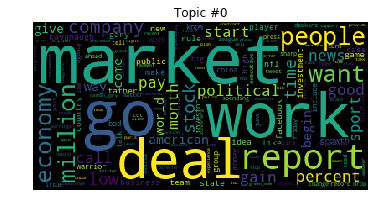

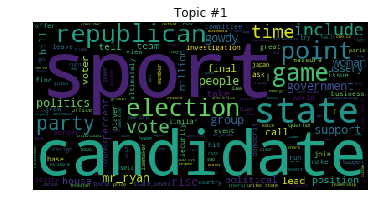

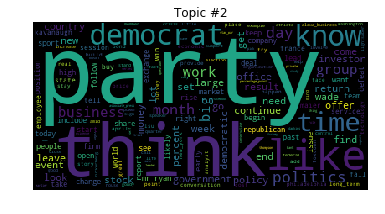

In [16]:
get_lda_topics(tokens_master, K=3, rand=2, detailed=True)

# Word Cloud for Business Only

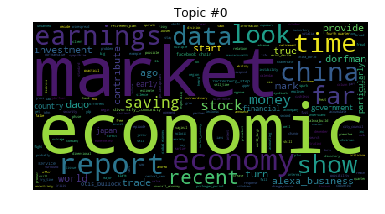

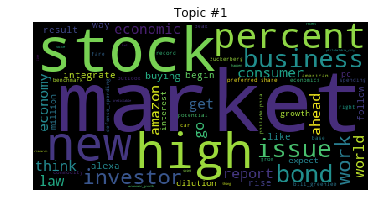

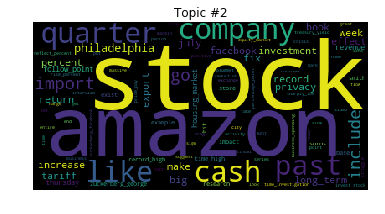

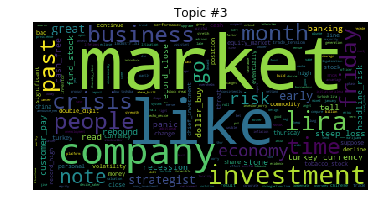

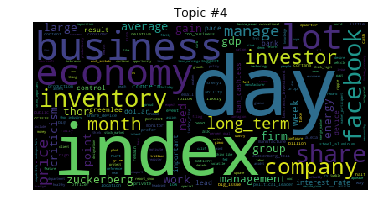

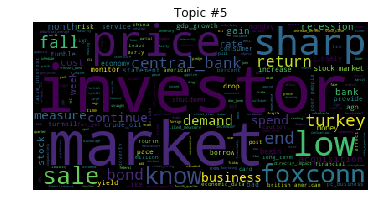

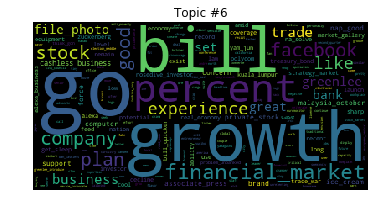

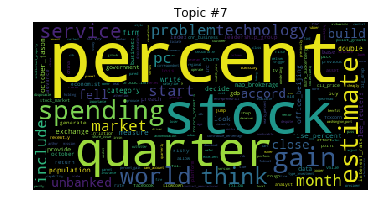

In [17]:
get_lda_topics(tokens_business, K=8, rand=1)

# Word Cloud for Politics Only

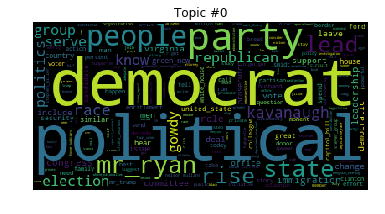

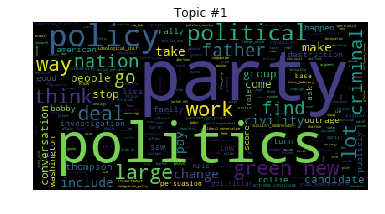

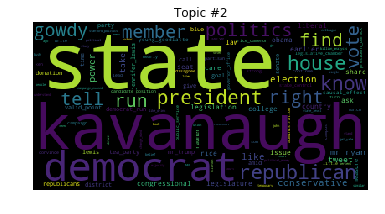

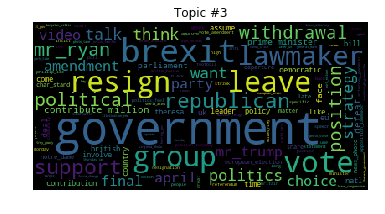

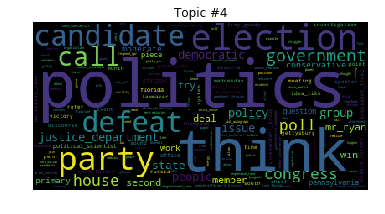

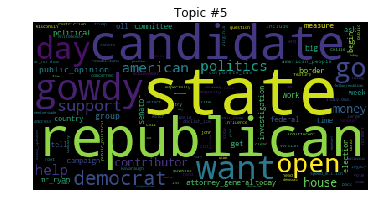

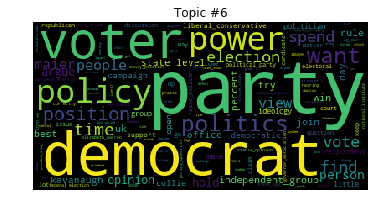

In [18]:
get_lda_topics(tokens_politics, K=7, rand=3)

# Word Cloud for Sports Only

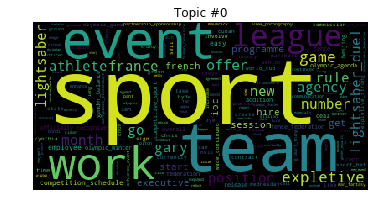

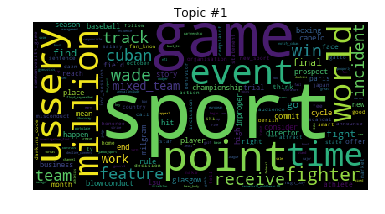

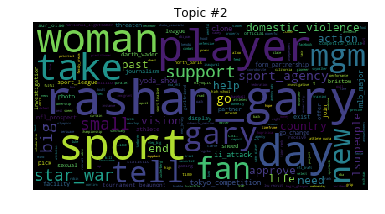

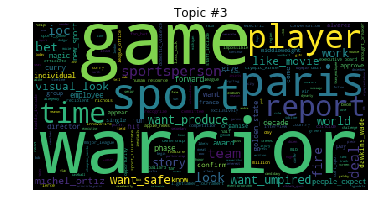

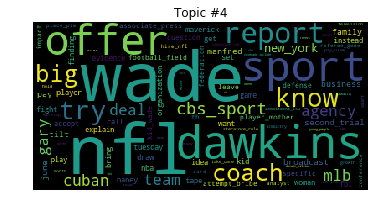

In [19]:
get_lda_topics(tokens_sports, K=5, rand=5)

# Applying Hierarchical Dirichlet Process
Hierarchical Dirichlet Process (HDP) is a powerful mixed-membership model for the unsupervised analysis of grouped data. Unlike a latent dirichlet allocation, the HDP topic model infers the number of topics from the data. In this model we seek to acquire the top 'n' topics from the HDP algorithm. 

In [40]:
def get_hdp_topics(tokens_list,top):
    common_dictionary = Dictionary(tokens_list)
    common_corpus = [common_dictionary.doc2bow(text) for text in tokens_list]
    hdp = HdpModel(common_corpus, id2word=common_dictionary)
    lda = hdp.suggested_lda_model()
    for t in range(top):
        plt.figure()
        plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t,200))))
        plt.axis("off")
        plt.title("Topic #" + str(t))

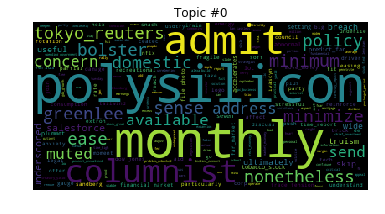

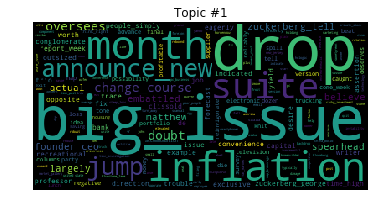

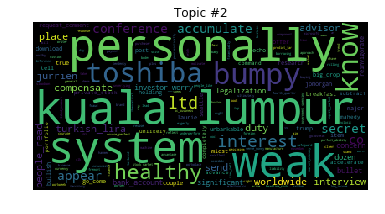

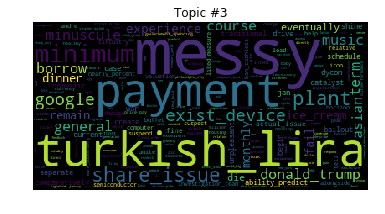

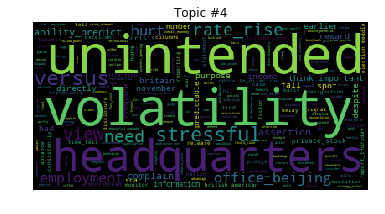

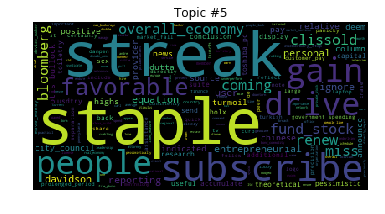

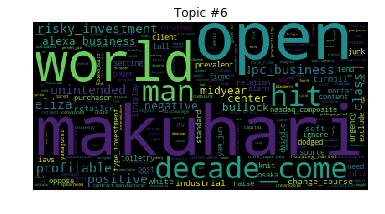

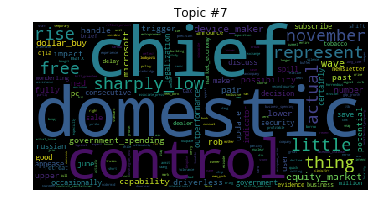

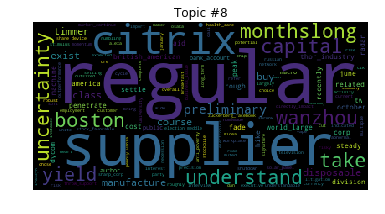

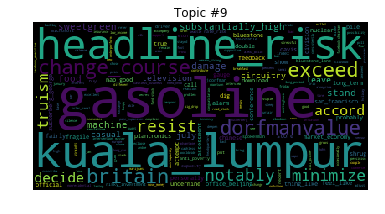

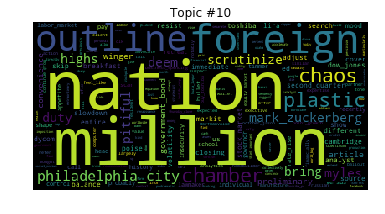

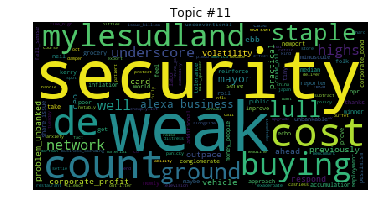

In [41]:
get_hdp_topics(tokens_business,top=12)

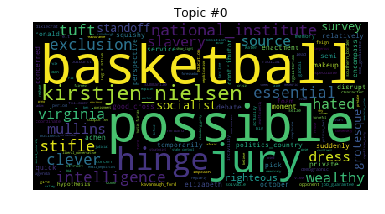

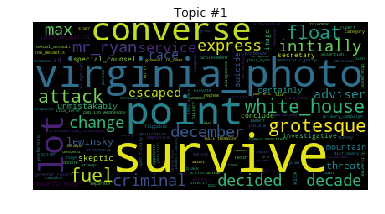

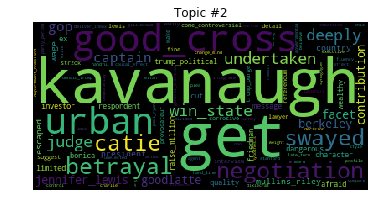

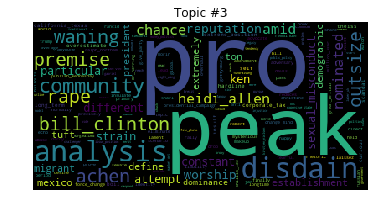

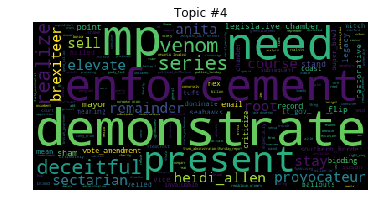

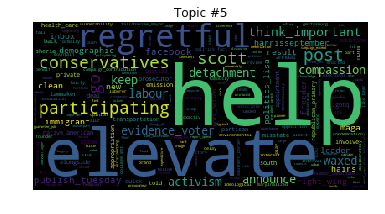

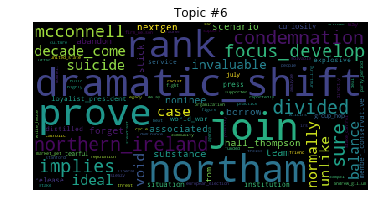

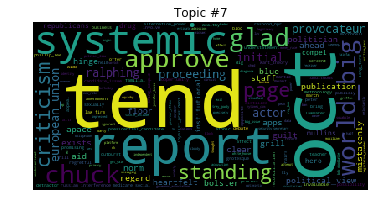

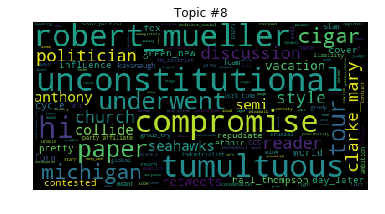

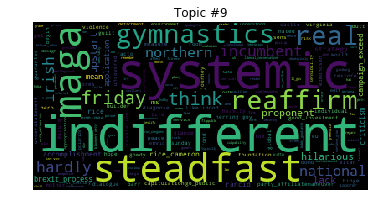

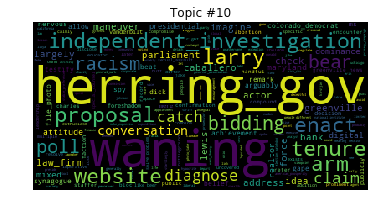

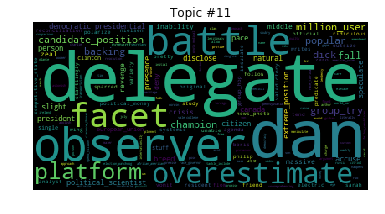

In [42]:
get_hdp_topics(tokens_politics,top=12)

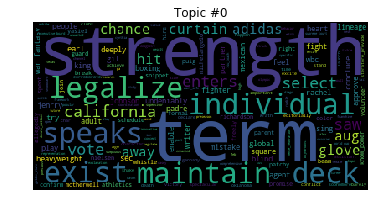

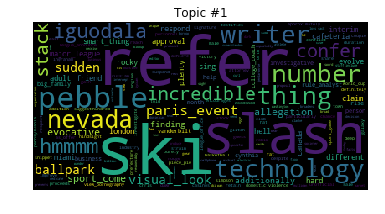

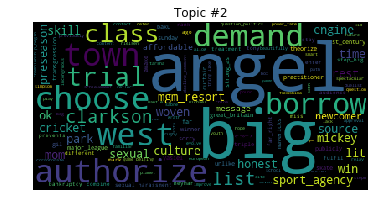

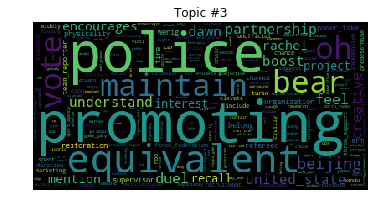

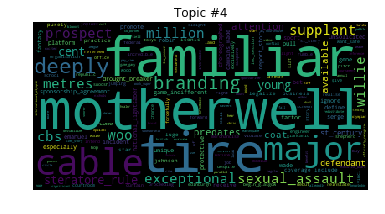

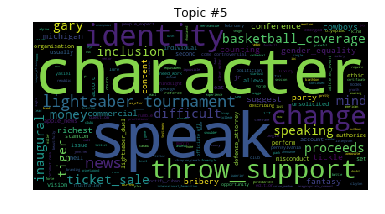

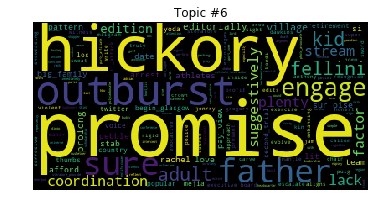

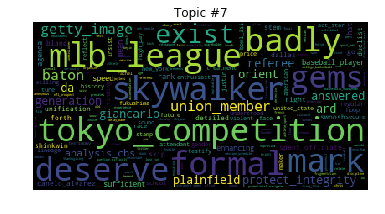

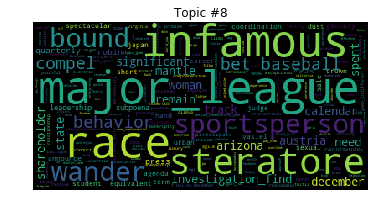

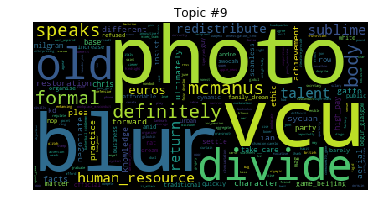

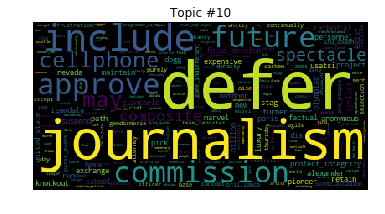

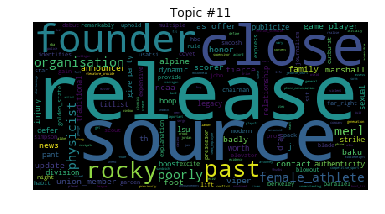

In [43]:
get_hdp_topics(tokens_sports,top=12)

# Concatenated Dataframe Process

In [44]:
df.head(3)

date      news  \
0 2019-03-08  Business   
1 2019-03-08  Business   
2 2019-03-08  Business   

                                                                                                                                                                                                                                                        text  \
0                                                                                                                                                                                   Protecting The 'Unbanked' By Banning Cashless Businesses In Philadelphia   
1                                              Philadelphia just became the first large city in the nation to ban cashless businesses in the city in part to protect people like Dwight Tindal a construction worker who doesn't have a bank or credit card.   
2  Back in December the Philadelphia City Council passed "Fair Workweek" legislation joining a growing national movement aimed at giving retail and fast-food workers more predictable schedules and by extension more predictable lives. Low-income resi...   

                                                                                                                                                                                                                                                     re_text  \
0                                                                                                                                                                                   protecting the  unbanked  by banning cashless businesses in philadelphia   
1                                              philadelphia just became the first large city in the nation to ban cashless businesses in the city in part to protect people like dwight tindal a construction worker who doesn t have a bank or credit card    
2  back in december the philadelphia city council passed  fair workweek  legislation joining a growing national movement aimed at giving retail and fast food workers more predictable schedules and by extension more predictable lives  low income resi...   

                                                                                                                                                                                                                                                  clean_text  
0                                                                                                                                                                                                 [protect, unbanked, ban, cashless, business, philadelphia]  
1                                                                                                        [philadelphia, large, city, nation, ban, cashless, business, city, protect, people, like, dwight, tindal, construction, worker, bank, credit, card]  
2  [december, philadelphia, city, council, pass, fair, workweek, legislation, join, grow, national, movement, aim, give, retail, fast, food, worker, predictable, schedule, extension, predictable, life, low, income, resident, union, lobby, lawmaker, ...

# Merge Paragraphs Together by Article & Date

In [45]:
df_agg = df.groupby(["news","date"]).clean_text.agg(sum).reset_index()
df_agg.head(6)

news       date  \
0  Business 2018-06-04   
1  Business 2018-07-02   
2  Business 2018-08-13   
3  Business 2018-09-20   
4  Business 2018-10-28   
5  Business 2018-11-21   

                                                                                                                                                                                                                                                  clean_text  
0  [sharp, buy, toshiba, pc, business, issue, billion, new, share, tokyo, reuters, japan, sharp, corp, buy, toshiba, corp, personal, computer, business, issue, billion, new, share, buy, preferred, stock, bank, highlight, swift, recovery, control, fo...  
1  [stock, bounce, potential, thor, industry, lam, research, love, buying, stock, point, quarterly, casualty, list, start, new, quarter, attention, stock, rough, previous, quarter, think, excellent, bounce, potential, series, article, successful, av...  
2  [stock, close, low, turkey, currency, crisis, dampen, risk, appetite, turkey, rattle, market, stock, close, low, monday, dow, jones, industrial, average, fourth, straight, session, ongoing, turmoil, turkey, dampen, investor, appetite, risky, asse...  
3  [record, highs, need, know, market, friday, stock, record, high, session, record, close, dow, jones, industrial, average, thursday, close, record, high, eclipse, previous, record, set, january, benchmark, hit, record, high, closing, snap, record,...  
4  [alexa, business, open, party, device, maker, amazon, announce, new, initiative, alexa, business, design, introduce, voice, assistant, technology, echo, device, corporate, setting, today, give, platform, big, upgrade, open, device, maker, build, ...  
5  [problem, pile, mark, zuckerberg, stand, ground, exclusive, cnn, business, interview, spend, apologize, facebook, misstep, ceo, mark, zuckerberg, defiant, exclusive, interview, cnn, business, tuesday, zuckerberg, resist, grow, call, change, faceb...

# Preparing for Document Topic Proportions

In [46]:
tokens_agg = df_agg.clean_text.values
dict_agg   = Dictionary(tokens_agg)
corpus_agg = [dict_agg.doc2bow(text) for text in tokens_agg]

# LDA Topic Model with K = 9

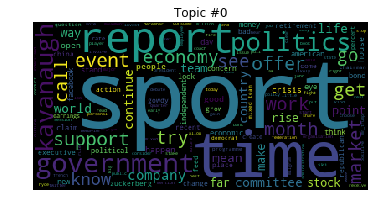

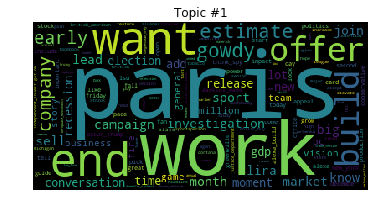

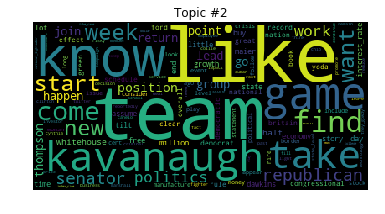

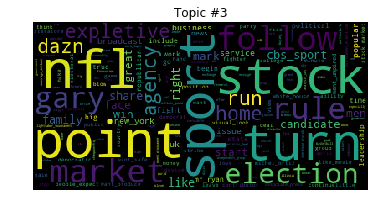

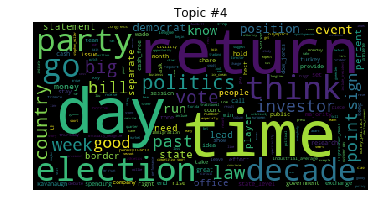

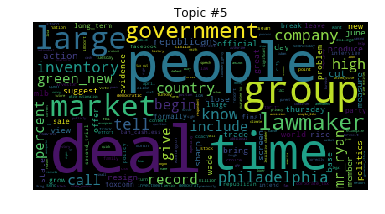

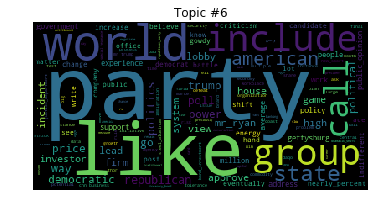

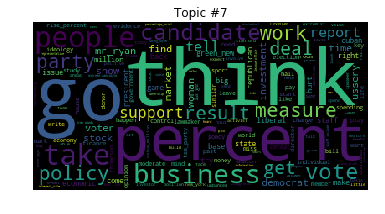

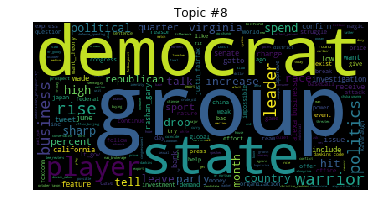

In [47]:
lda = get_lda(tokens_master, K=9, rand=1)
get_lda_topics(tokens_master, K=9, rand=1)

# Document Topic Proportions Result

Each row shows a news article and how much of the text was about each topic (#0-#8), thereby making up a distribution over topics.

In [48]:
topic_props = [lda.get_document_topics(doc,minimum_probability=0) for doc in corpus_agg]
topic_props_df = pd.DataFrame(topic_props)

for each in topic_props_df.columns:
    df_agg[each] = topic_props_df[each].apply(lambda x: x[1])

df_agg.to_csv("Matrix1.csv")
df_agg.tail()

news       date  \
25  Sports 2018-11-27   
26  Sports 2018-12-10   
27  Sports 2019-01-22   
28  Sports 2019-02-18   
29  Sports 2019-03-07   

                                                                                                                                                                                                                                                   clean_text  \
25  [mlb, major, sport, league, form, partnership, mgm, mlb, major, sport, league, form, partnership, mgm, mgm, resort, ceo, jam, murren, leave, mlb, commissioner, rob, manfred, shake, hand, news, conference, mlb, headquarter, new, york, tuesday, set...   
26  [editor, golden, state, warrior, si, sportsperson, honoree, decade, sport, gift, team, sublime, impossible, separate, individual, rest, group, extraordinary, golden, state, warrior, recipient, th, sport, illustrate, sportsperson, award, warrior, ...   
27  [nfl, prospect, rashan, gary, pioneer, sport, agency, rashan, gary, living, dream, founder, ceo, sport, agency, defensive, end, project, pick, nfl, draft, fulfil, vision, high, school, star, new, jersey, develop, mind, past, michigan, dream, play...   
28  [lightsaber, duel, officially, recognize, competitive, sport, france, france, easy, act, star, war, fantasy, fence, federation, officially, recognize, lightsaber, duel, competitive, sport, beaumont, sur, oise, france, ap, master, yoda, dust, fren...   
29  [phone, conversation, intercept, fbi, lsu, coach, wade, basketball, middleman, christian, dawkins, feature, wade, speak, freely, strong, as, offer, recruitment, prospect, yahoo, sport, learn, wade, express, frustration, party, affiliate, recruitm...   

           0         1         2         3         4         5         6  \
25  0.102047  0.038525  0.095288  0.135894  0.107611  0.099180  0.115639   
26  0.235624  0.058702  0.215107  0.060329  0.239839  0.043886  0.076509   
27  0.079148  0.025904  0.230234  0.153518  0.095485  0.083493  0.120448   
28  0.105976  0.073100  0.085084  0.205973  0.121334  0.126170  0.074456   
29  0.094629  0.059781  0.175298  0.054046  0.241585  0.039566  0.086222   

           7         8  
25  0.179958  0.125859  
26  0.044764  0.025242  
27  0.175628  0.036142  
28  0.104899  0.103008  
29  0.043541  0.205331

# Paris/France Analysis
We were interested in plotting the proportion or distribution of these articles that discussed Paris. We noticed that around July through September there was a big amount of Sports articles, this was probably due to the World Cup and France being the champions of it. Afterwards, around late October and November, there was a significant drop in all news related to Paris. Then all of sudden, all three types of news spiked interest in Paris again, this was due to the yellow-vest protests. The Paris/France protests started to gain momentum around late November, which is exactly what the data presents! Obervation: Through our own intuition and the help of document matrixes, we can understand the recent happenings of a topic in a better manner than we would've by just reading news.

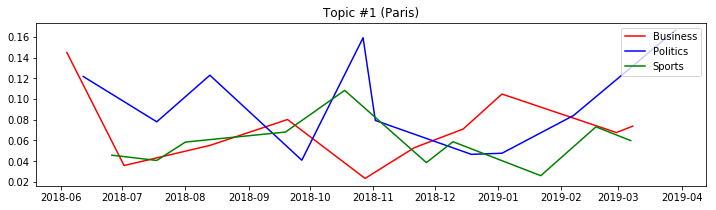

In [51]:
df_agg.sort_values(["news","date"])

business = df_agg[df_agg.news == "Business"]
politics = df_agg[df_agg.news == "Politics"]
sports   = df_agg[df_agg.news == "Sports"]

plt.plot(business["date"], business[1], "r-", label="Business")
plt.plot(politics["date"], politics[1], "b-", label="Politics")
plt.plot(sports["date"], sports[1], "g-", label="Sports")
plt.legend()
plt.title("Topic #1 (Paris)")
plt.rcParams['figure.figsize'] = [12,3]
plt.show()

# Changing LDA's K to 20 topics

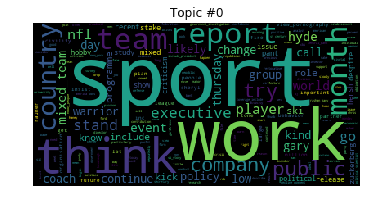

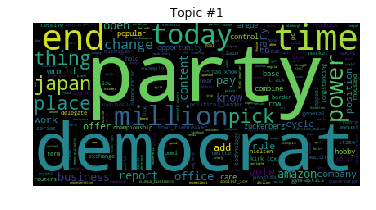

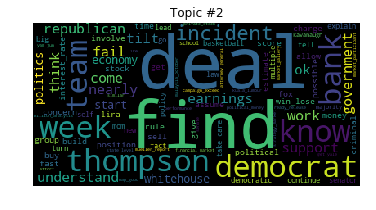

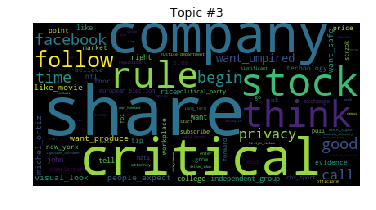

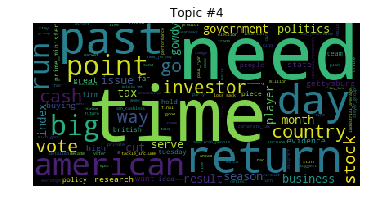

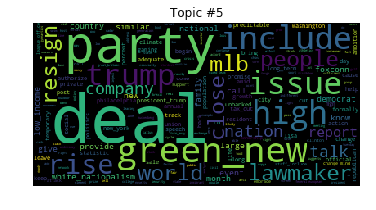

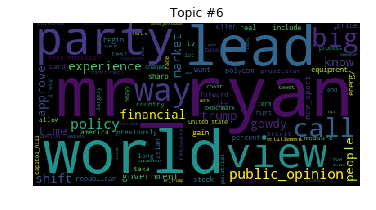

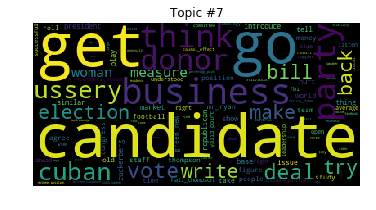

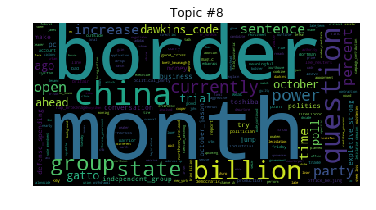

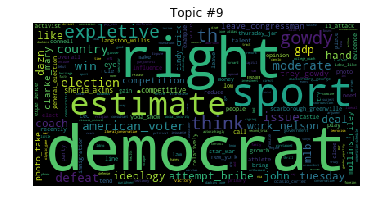

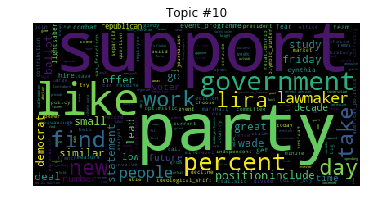

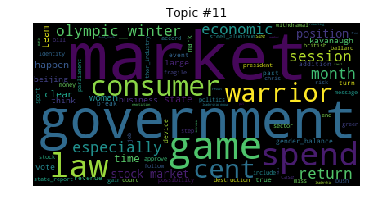

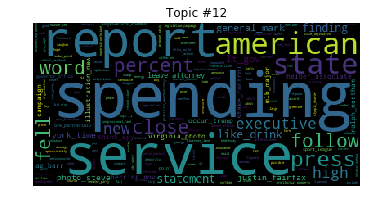

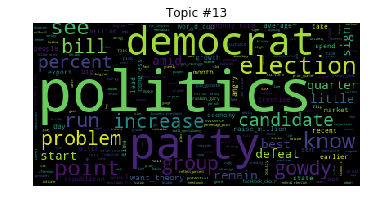

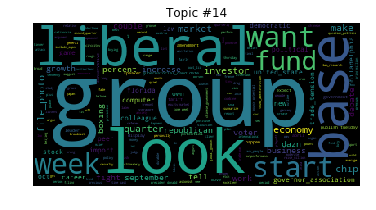

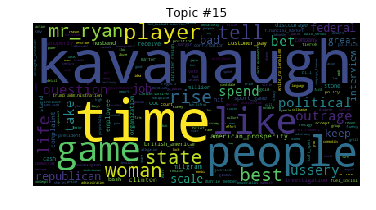

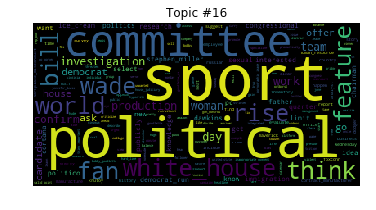

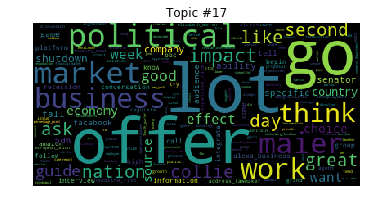

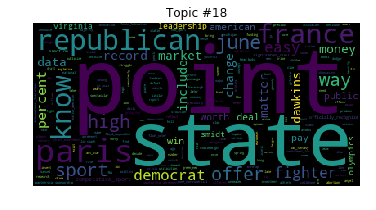

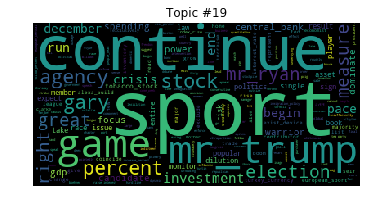

In [52]:
lda = get_lda(tokens_master, K=20, rand=1)
get_lda_topics(tokens_master, K=20, rand=1)

# Re-Set Up of Document Topic Proportions
This time we aim to understand "spending" across the three types of news.

In [53]:
topic_props = [lda.get_document_topics(doc,minimum_probability=0) for doc in corpus_agg]
topic_props_df = pd.DataFrame(topic_props)

for each in topic_props_df.columns:
    df_agg[each] = topic_props_df[each].apply(lambda x: x[1])
    
df_agg.to_csv("Matrix2.csv")

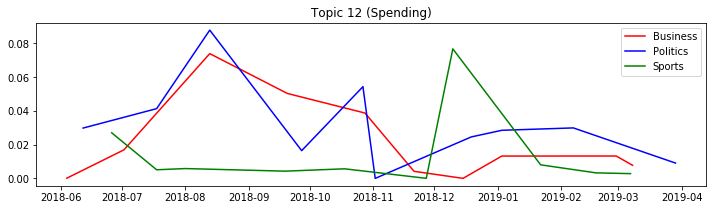

In [55]:
df_agg.sort_values(["news","date"])

business = df_agg[df_agg.news == "Business"]
politics = df_agg[df_agg.news == "Politics"]
sports   = df_agg[df_agg.news == "Sports"]

plt.plot(business["date"], business[12], "r-", label="Business")
plt.plot(politics["date"], politics[12], "b-", label="Politics")
plt.plot(sports["date"], sports[12], "g-", label="Sports")
plt.legend()
plt.title("Topic 12 (Spending)")
plt.show()

# Testing Unseen Documents with LDA

In [56]:
def get_unseen_df():
    files = ["Test_B1","Test_P1","Test_P2","Test_S1","Test_S2"]
    df_list = list()
    path = "2_csv_text/"
    for file in files:
        df = pd.read_csv(path+file+".csv",header=None)
        df.drop(df.columns[0], axis=1,inplace=True)
        df_list.append(df)
    df = pd.concat(df_list,ignore_index=True)
    df.columns = ["date","news","text"]
    df["date"] = pd.to_datetime(df["date"], format='%m-%d-%Y')
    count = df['text'].str.split().str.len()
    return df[~(count < 4)]

df = get_unseen_df()

## Apply Pre-Processing to Unseen Document Dataframe

In [57]:
df['re_text'] = df.text.apply(lambda text: re.sub("'|\.|\s+|\d+|[^a-zA-Z0-9]"," ", str(text).lower()))
df['clean_text'] = df.re_text.apply(lambda text: tokenize_lemmatize_removestops(text))
df.dropna(inplace=True)

## Concatenate and Format for LDA Model

In [58]:
df_unseen = df.groupby(["news","date"]).clean_text.agg(sum).reset_index()
tokens_unseen = df_unseen.clean_text.values
unseen_doc = [dict_agg.doc2bow(text) for text in tokens_unseen]

## Results

news       date  \
0  Business 2018-08-13   
1  Politics 2018-11-02   
2  Politics 2019-03-29   
3    Sports 2018-08-01   
4    Sports 2018-09-19   

                                                                                                                                                                                                                                                  clean_text  \
0  [stock, close, low, turkey, currency, crisis, dampen, risk, appetite, turkey, rattle, market, stock, close, low, monday, dow, jones, industrial, average, fourth, straight, session, ongoing, turmoil, turkey, dampen, investor, appetite, risky, asse...   
1  [political, money, state, level, campaign, exceed, billion, analysis, find, stake, control, governor, office, legislative, chamber, state, political, money, state, level, campaign, exceed, billion, analysis, find, combination, oct, file, photo, f...   
2  [independent, group, mps, political, party, heidi, allen, gavin, shukerpa, heidi, allen, group, hop, attract, candidate, walk, life, independent, group, tig, mp, apply, political, party, european, election, ahead, group, intend, change, uk, name,...   
3  [european, sport, championship, launch, new, spectacle, sport, mark, woodswed, aug, edt, athletics, take, bill, inaugural, day, jamboree, begin, glasgow, back, seven, federation, inaugural, european, sport, championship, begin, glasgow, thursday,...   
4  [maverick, workplace, misconduct, report, cuban, donate, million, si, com, maverick, owner, mark, cuban, agree, nba, donate, million, organization, promote, woman, leadership, roles, combat, domestic, violence, result, independent, investigation,...   

          0         1         2  
0  0.220370  0.200708  0.578923  
1  0.326450  0.420062  0.253488  
2  0.305380  0.280519  0.414100  
3  0.282158  0.369752  0.348090  
4  0.196969  0.499635  0.303397

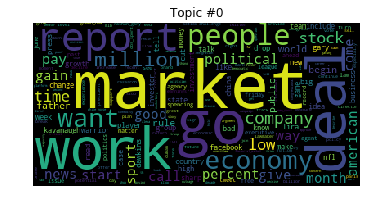

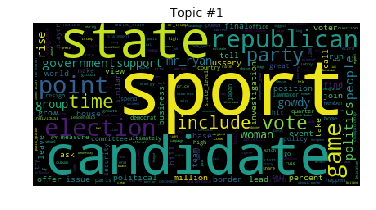

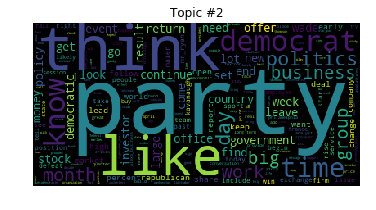

In [60]:
lda = get_lda(tokens_master, K=3, rand=2)
unseen_lda = lda[unseen_doc]

topic_props = [lda.get_document_topics(doc,minimum_probability=0) for doc in unseen_doc]
topic_props_df = pd.DataFrame(topic_props)

for each in topic_props_df.columns:
    df_unseen[each] = topic_props_df[each].apply(lambda x: x[1])

df_unseen.to_csv("MatrixUnseen.csv")
get_lda_topics(tokens_master, K=3, rand=2)
df_unseen